In [1]:
import sys
sys.path.append('/mnt/nas/minici/UrbRecLoop')


In [2]:
from model.recommender3 import MultiVAE, MatrixFactorization
from model import user
from datetime import timedelta
import glob
import tqdm
import os
import pandas as pd
import numpy as np

def filtering_training_data(training_dataset, min_activity):
    # Count the number of rows per user
    user_counts = training_dataset['uid'].value_counts()
    # Get the users with at least x rows
    valid_users = user_counts[user_counts >= min_activity].index
    # Filter the DataFrame to include only valid users
    filtered_dataset = training_dataset[training_dataset['uid'].isin(valid_users)]
    return filtered_dataset

def create_interaction_matrix(data):
    interaction_counts = data.groupby(['uid', 'venueID']).size().reset_index(name='counts')
    interaction_matrix = interaction_counts.pivot(index='uid', columns='venueID', values='counts').fillna(0)
    return interaction_matrix


def calculate_metrics(recommended_venues, real_visited_venues):
    recommended_venues = list(recommended_venues)
    real_visited_venues = set(real_visited_venues)

    # Calculate hits
    hits = [1 if venue in real_visited_venues else 0 for venue in recommended_venues]

    # Precision
    precision = sum(hits) / len(recommended_venues) if recommended_venues else 0

    # Recall
    recall = sum(hits) / len(real_visited_venues) if real_visited_venues else 0

    # NDCG
    dcg = 0
    idcg = 0
    for i, hit in enumerate(hits, 1):
        if hit:
            dcg += 1 / np.log2(i + 1)
    for i in range(1, len(real_visited_venues) + 1):
        idcg += 1 / np.log2(i + 1)
    ndcg = dcg / idcg if idcg > 0 else 0

    # MRR
    mrr = 0
    for i, hit in enumerate(hits, 1):
        if hit:
            mrr = 1 / i
            break

    # Hit Rate
    hit_rate = 1 if any(hits) else 0

    return {
        'ndcg': ndcg,
        'precision': precision,
        'recall': recall,
        'mrr': mrr,
        'hitrate': hit_rate
    }


In [5]:
# DATASET HYPER-PARAMETERS #
city = "nyc"
city_files = glob.glob('*_visits.csv')
data_file = f"../data/processed/foursquare_complete_{city}_cp_small.csv"
train_window = 60  # Training window in days
k_days = 7  # Epoch length in days
threshold = 100  # Performance degradation threshold (adjust as needed)
max_simulation_days = 90  # Maximum number of simulation days
min_activity = 5  
topK = 20

# RECSYS HYPER-PARAMETERS #
# MF
num_latent_factors = 32
# UserKNN
num_nearest_neighbors = 5


In [11]:
# DATA LOADING
dataset = pd.read_csv(data_file)
print(f'Dataset has {len(dataset)} records.')
dataset['time'] = pd.to_datetime(dataset['time'])
dataset['uid'] = dataset['uid'].astype(int)
dataset['venueID'] = dataset['venueID'].astype(str)
#drop duplicates
dataset = dataset.drop_duplicates()
# self.city_name = os.path.basename(data_file).split('_')[0]
print(f'Dataset has {len(dataset)} records after removing duplicates.')
# Set training period
start_date = dataset['time'].min()
training_duration = timedelta(days=train_window)
t = start_date + training_duration
# Training data
train_data = dataset[dataset['time'] < t]
# Filtering out users with few interactions (visited less than X POIs)
train_data = filtering_training_data(train_data, min_activity)
# Simulation data==Test data
test_data = dataset[dataset['time'] >= t]
# Excluding users not present in the training dataset
test_data = test_data[test_data['uid'].isin(train_data['uid'].unique())]
test_data = test_data[test_data['venueID'].isin(train_data['venueID'].unique())]
# Prepare interaction matrix
X_train = create_interaction_matrix(train_data)


Dataset has 50000 records.
Dataset has 49950 records after removing duplicates.


In [41]:
from model.recommender3 import MultiVAE, VAE
import torch
import torch.nn.functional as F

def loss_function(recon_x, x, mu, logvar):
    # Using binary cross-entropy as reconstruction loss
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, BCE, KLD
recommender = MultiVAE(300, 128, dropout=0.25, epochs=50, lr=0.001, patience=5, device='cpu')


In [42]:
# Map users and items to indices
recommender.user_index = {user: idx for idx, user in enumerate(X_train.index)}
recommender.item_index = {item: idx for idx, item in enumerate(X_train.columns)}

# Fill missing values and convert the DataFrame to a numpy array.
data_matrix = X_train.fillna(0).values.astype(np.float32)
data_matrix[data_matrix > 0] = 1.0
recommender.user_item_matrix = torch.FloatTensor(data_matrix).to(recommender.device)

input_dim = recommender.user_item_matrix.shape[1]

# Initialize the VAE model and optimizer
recommender.model = VAE(input_dim, recommender.hidden_dim, recommender.latent_dim, recommender.dropout).to(recommender.device)
recommender.optimizer = torch.optim.Adam(recommender.model.parameters(), lr=recommender.lr)

recommender.model.train()

best_loss = float('inf')
epochs_without_improvement = 0


In [43]:
loss_list=list()
bce_loss_list=list()
kld_div_list=list()
for epoch in range(recommender.epochs):
    recommender.optimizer.zero_grad()
    recon_batch, mu, logvar = recommender.model(recommender.user_item_matrix)
    loss, bce_loss, kld_div = loss_function(recon_batch, recommender.user_item_matrix, mu, logvar)
    loss.backward()
    recommender.optimizer.step()
    loss_list.append(loss.item())
    bce_loss_list.append(bce_loss.item())
    kld_div_list.append(kld_div.item())

    # Check for improvement
    if loss.item() < best_loss:
        best_loss = loss.item()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    # Optionally print loss information
    # print(f"Epoch {epoch+1}/{self.epochs}, Loss: {loss.item():.2f}")

    # Early stopping condition
    if epochs_without_improvement >= recommender.patience:
        # Optionally print early stopping message
        # print(f"Stopping early at epoch {epoch+1} with best loss {best_loss:.2f}")
        break



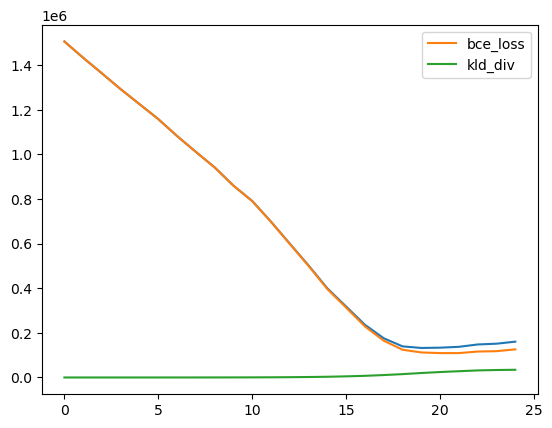

In [44]:
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.plot(bce_loss_list, label='bce_loss')
plt.plot(kld_div_list, label='kld_div')
plt.legend()
